In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

from __future__ import print_function
import PIL.Image as Image
import matplotlib.pyplot as plt
import copy
import numpy as np

use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

The following code for the NST algorithm was referenced from the work of 
Sunghyun (psh01087) on GitHub.

In [4]:
imsize = 512 if use_cuda else 128

transform = transforms.Compose([transforms.Resize([imsize,imsize]), transforms.ToTensor()])

def image_loader(image_name, transform=None, max_size=None, shape=None):
    image = Image.open(image_name)
    
    if max_size is not None:
        scale = max_size / max(image.size)
        size = np.array(image.size) * scale
        image = image.resize(size.astype(int), Image.ANTIALIAS)
    
    if shape is not None:
        image = image.resize(shape, Image.LANCZOS)
    
    if transform is not None:
        image = transform(image)
        
    image = Variable(image)
    image = image.unsqueeze(0)
    
    return image.type(dtype)

In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.loss = self.criterion(input * self.weight, self.target)
        self.output = input
        return self.output

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

In [ ]:
class GramMatrix(nn.Module):

    def forward(self, input):
        a, b, c, d = input.size()
        features = input.view(a * b, c * d)
        G = torch.mm(features, features.t())
        return G.div(a * b * c * d)

In [ ]:
class StyleLoss(nn.Module):

    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram(input)
        self.G.mul_(self.weight)
        self.loss = self.criterion(self.G, self.target)
        return self.output

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

In [ ]:
cnn = models.vgg19(pretrained=True).features

# move it to the GPU if possible:
if use_cuda:
    cnn = cnn.cuda()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']


def get_style_model_and_losses(cnn, style_img, content_img,
                               style_weight=1000, content_weight=1,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    model = nn.Sequential()  # the new Sequential module network
    gram = GramMatrix()  # we need a gram module in order to compute style targets

    # move these modules to the GPU if possible:
    if use_cuda:
        model = model.cuda()
        gram = gram.cuda()

    i = 1
    for layer in list(cnn):
        if isinstance(layer, nn.Conv2d):
            name = "conv_" + str(i)
            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)

        if isinstance(layer, nn.ReLU):
            name = "relu_" + str(i)
            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)

            i += 1

        if isinstance(layer, nn.MaxPool2d):
            name = "pool_" + str(i)
            model.add_module(name, layer)  # ***

    return model, style_losses, content_losses

In [ ]:
# Optimizer (LBFGS)
def get_input_param_optimizer(input_img):
    input_param = nn.Parameter(input_img.data)
    optimizer = optim.LBFGS([input_param])
    return input_param, optimizer

In [ ]:
import time

In [ ]:
def train_style_transfer(cnn, content_img, style_img, input_img, num_steps=300,
                       style_weight=1000, content_weight=1):
    start_time = time.time()
    print('Starting style transfer!!')
    model, style_losses, content_losses = get_style_model_and_losses(cnn, style_img, content_img, style_weight, content_weight)
    input_param, optimizer = get_input_param_optimizer(input_img)

    ss = []
    cs = []
    
    run = [0]
    while run[0] <= num_steps:
        def steps():
            input_param.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_param)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.backward()
            for cl in content_losses:
                content_score += cl.backward()

            run[0] += 1
            ss.append(style_score.item())
            cs.append(content_score.item())
            if run[0] % 50 == 0:
                print("run {}: Style Loss : {:4f} Content Loss: {:4f}".format(run, style_score.item(), content_score.item()))

            return style_score + content_score

        optimizer.step(steps)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(elapsed_time)
    # a last correction...
    input_param.data.clamp_(0, 1)

    return input_param.data, ss, cs

Conducting Style Transfer Tests

In [5]:
content_img = image_loader("gdrive/My Drive/ECE324/Project/CartoonGAN/Data/facesketch.jpeg", transform, max_size=imsize)
style_img = image_loader("gdrive/My Drive/ECE324/Project/CartoonGAN/Data/hawk.jpeg", transform, shape=[content_img.size(2), content_img.size(3)])
input_img = content_img.clone()

In [6]:
c = Image.open("gdrive/My Drive/ECE324/Project/CartoonGAN/Data/facesketch.jpeg").convert("RGB")
s = img = Image.open("gdrive/My Drive/ECE324/Project/CartoonGAN/Data/hawk.jpeg").convert("RGB")

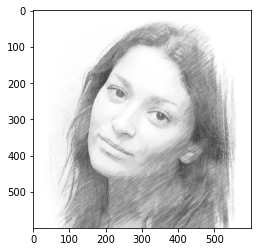

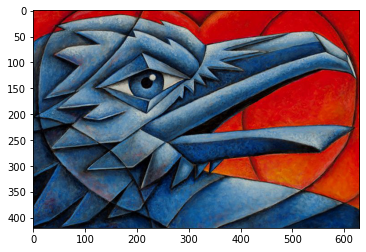

In [7]:
plt.imshow(c)
plt.figure()
plt.imshow(s)

In [ ]:
output,ss ,cs = train_style_transfer(cnn, content_img, style_img, input_img)

Starting style transfer!!
run [50]: Style Loss : 14.366570 Content Loss: 2.520398
run [100]: Style Loss : 6.793773 Content Loss: 2.541986
run [150]: Style Loss : 1.754611 Content Loss: 2.615124
run [200]: Style Loss : 0.692398 Content Loss: 2.645640
run [250]: Style Loss : 0.469781 Content Loss: 2.281072
run [300]: Style Loss : 0.278848 Content Loss: 2.174178
199.06159734725952


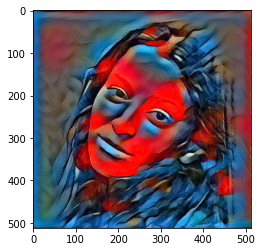

In [ ]:
nout = output.squeeze()
nout.shape
nout = nout.permute(1,2,0)
plt.imshow(nout.cpu().detach().numpy())

In [ ]:
nout.shape
nnout = nout.permute(2,1,0)
nnout.shape

torch.Size([3, 512, 512])

In [ ]:
torchvision.utils.save_image(nout.permute(2,1,0), "gdrive/My Drive/ECE324/Project/CartoonGAN/Result/out.jpg")

In [ ]:
nout = output.squeeze()
nout.shape
nout = nout.permute(1,2,0)

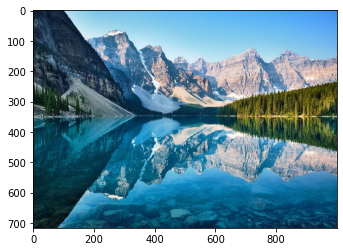

In [ ]:
img = Image.open("gdrive/My Drive/ECE324/Project/CartoonGAN/Data/banff.jpeg").convert("RGB")
plt.imshow(img)

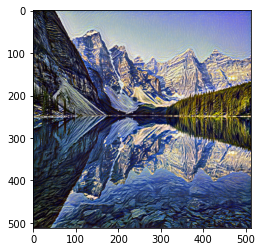

In [ ]:
plt.imshow(nout.cpu().detach().numpy())

Transfer 2

In [ ]:
content_img = image_loader("gdrive/My Drive/ECE324/Project/CartoonGAN/Data/ink.jpeg", transform, max_size=imsize)
style_img = image_loader("gdrive/My Drive/ECE324/Project/CartoonGAN/Data/starry.jpeg", transform, shape=[content_img.size(2), content_img.size(3)])
input_img = content_img.clone()

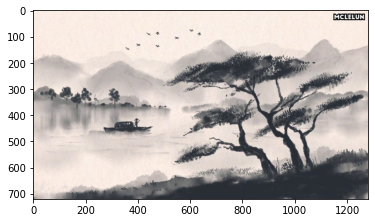

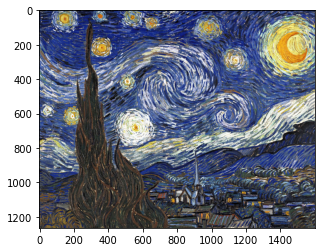

In [8]:
c = Image.open("gdrive/My Drive/ECE324/Project/CartoonGAN/Data/ink.jpeg").convert("RGB")
s = img = Image.open("gdrive/My Drive/ECE324/Project/CartoonGAN/Data/starry.jpeg").convert("RGB")
plt.imshow(c)
plt.figure()
plt.imshow(s)

In [ ]:
output = train_style_transfer(cnn, content_img, style_img, input_img)

Starting style transfer!!
run [50]: Style Loss : 5.130697 Content Loss: 6.378026
run [100]: Style Loss : 2.912570 Content Loss: 5.695755
run [150]: Style Loss : 1.637121 Content Loss: 5.407619
run [200]: Style Loss : 0.630995 Content Loss: 5.292791
run [250]: Style Loss : 0.750904 Content Loss: 5.241051
run [300]: Style Loss : 0.221077 Content Loss: 5.093031


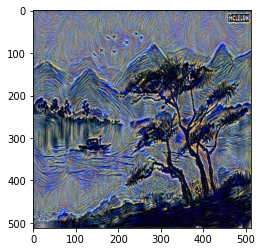

In [ ]:
nout = output.squeeze()
nout.shape
nout = nout.permute(1,2,0)
plt.imshow(nout.cpu().detach().numpy())

Transfer 3

In [ ]:
content_img = image_loader("gdrive/My Drive/ECE324/Project/CartoonGAN/Data/wano.jpg", transform, max_size=imsize)
#content_img.shape
style_img = image_loader("gdrive/My Drive/ECE324/Project/CartoonGAN/Data/ink.jpeg", transform, shape=[content_img.size(2), content_img.size(3)])
input_img = content_img.clone()

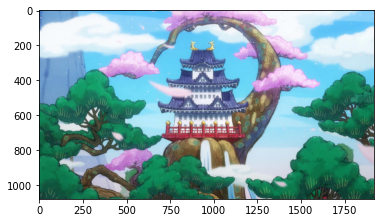

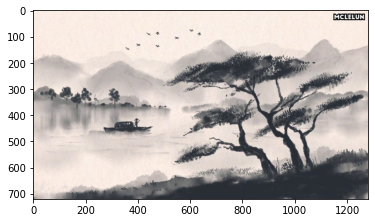

In [9]:
c = Image.open("gdrive/My Drive/ECE324/Project/CartoonGAN/Data/wano.jpg").convert("RGB")
s = img = Image.open("gdrive/My Drive/ECE324/Project/CartoonGAN/Data/ink.jpeg").convert("RGB")
plt.imshow(c)
plt.figure()
plt.imshow(s)

In [ ]:
output = train_style_transfer(cnn, content_img, style_img, input_img)

Starting style transfer!!
run [50]: Style Loss : 0.905600 Content Loss: 0.991613
run [100]: Style Loss : 0.524572 Content Loss: 0.748750
run [150]: Style Loss : 0.183296 Content Loss: 0.827400
run [200]: Style Loss : 0.157847 Content Loss: 0.771877
run [250]: Style Loss : 0.163901 Content Loss: 0.744128
run [300]: Style Loss : 0.130629 Content Loss: 0.699155


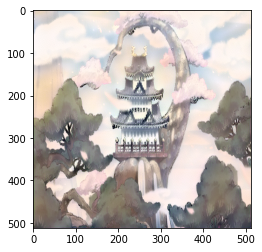

In [ ]:
nout = output.squeeze()
nout.shape
nout = nout.permute(1,2,0)
plt.imshow(nout.cpu().detach().numpy())

Transfer 4

In [ ]:
content_img = image_loader("gdrive/My Drive/ECE324/Project/CartoonGAN/Data/ink.jpeg", transform, max_size=imsize)
style_img = image_loader("gdrive/My Drive/ECE324/Project/CartoonGAN/Data/cube.jpeg", transform, shape=[content_img.size(2), content_img.size(3)])
input_img = content_img.clone()

In [ ]:
output = train_style_transfer(cnn, content_img, style_img, input_img)

Starting style transfer!!
run [50]: Style Loss : 2.273775 Content Loss: 1.828664
run [100]: Style Loss : 1.043536 Content Loss: 1.749271
run [150]: Style Loss : 0.309008 Content Loss: 1.711344
run [200]: Style Loss : 0.119019 Content Loss: 1.674988
run [250]: Style Loss : 0.156332 Content Loss: 1.608391
run [300]: Style Loss : 0.117644 Content Loss: 1.583078


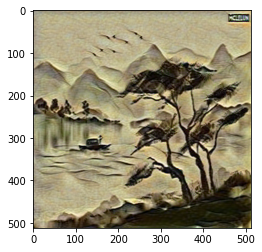

In [ ]:
nout = output.squeeze()
nout.shape
nout = nout.permute(1,2,0)
plt.imshow(nout.cpu().detach().numpy())

Transfer 5

In [ ]:
content_img = image_loader("gdrive/My Drive/ECE324/Project/CartoonGAN/Data/s3.jpeg", transform, max_size=imsize)
style_img = image_loader("gdrive/My Drive/ECE324/Project/CartoonGAN/Data/cubef.jpeg", transform, shape=[content_img.size(2), content_img.size(3)])
input_img = content_img.clone()

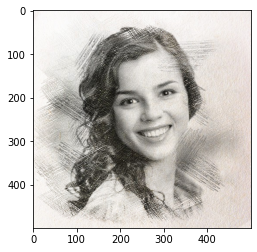

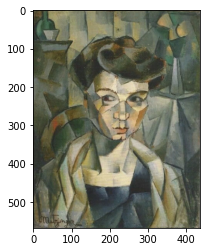

In [10]:
c = Image.open("gdrive/My Drive/ECE324/Project/CartoonGAN/Data/s3.jpeg").convert("RGB")
s = img = Image.open("gdrive/My Drive/ECE324/Project/CartoonGAN/Data/cubef.jpeg").convert("RGB")
plt.imshow(c)
plt.figure()
plt.imshow(s)

Starting style transfer!!
run [50]: Style Loss : 95.853340 Content Loss: 2.560217
run [100]: Style Loss : 6.761026 Content Loss: 3.049399
run [150]: Style Loss : 0.662267 Content Loss: 2.567904
run [200]: Style Loss : 0.400954 Content Loss: 2.002975
run [250]: Style Loss : 0.316242 Content Loss: 1.704824
run [300]: Style Loss : 0.270214 Content Loss: 1.555437
194.43629932403564


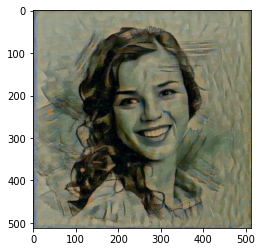

In [ ]:
output,ss ,cs = train_style_transfer(cnn, content_img, style_img, input_img,style_weight=6000)
nout = output.squeeze()
nout.shape
nout = nout.permute(1,2,0)
plt.imshow(nout.cpu().detach().numpy())

In [ ]:
torchvision.utils.save_image(nout.permute(2,0,1), "gdrive/My Drive/ECE324/Project/CartoonGAN/Result/out5.jpg")

Transfer 6

In [ ]:
content_img = image_loader("gdrive/My Drive/ECE324/Project/CartoonGAN/Data/furg.jpg", transform, max_size=imsize)
style_img = image_loader("gdrive/My Drive/ECE324/Project/CartoonGAN/Data/cubesup.jpeg", transform, shape=[content_img.size(2), content_img.size(3)])
input_img = content_img.clone()

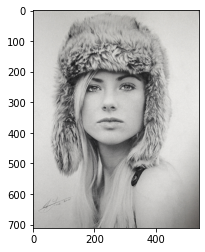

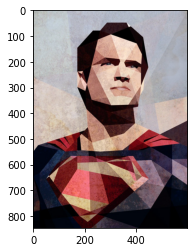

In [11]:
c = Image.open("gdrive/My Drive/ECE324/Project/CartoonGAN/Data/furg.jpg").convert("RGB")
s = img = Image.open("gdrive/My Drive/ECE324/Project/CartoonGAN/Data/cubesup.jpeg").convert("RGB")
plt.imshow(c)
plt.figure()
plt.imshow(s)

Starting style transfer!!
run [50]: Style Loss : 30.546375 Content Loss: 1.736483
run [100]: Style Loss : 12.590077 Content Loss: 2.014585
run [150]: Style Loss : 2.535880 Content Loss: 2.158401
run [200]: Style Loss : 1.140519 Content Loss: 1.880597
run [250]: Style Loss : 0.929280 Content Loss: 1.630298
run [300]: Style Loss : 0.762853 Content Loss: 1.538419
193.40680599212646


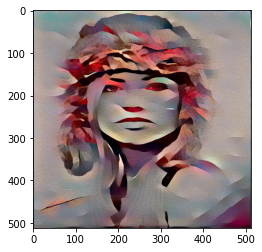

In [ ]:
output,ss ,cs = train_style_transfer(cnn, content_img, style_img, input_img, style_weight=4000)
nout = output.squeeze()
nout.shape
nout = nout.permute(1,2,0)
plt.imshow(nout.cpu().detach().numpy())

In [ ]:
torchvision.utils.save_image(nout.permute(2,0,1), "gdrive/My Drive/ECE324/Project/CartoonGAN/Result/out4.jpg")

Transfer 8

In [ ]:
content_img = image_loader("gdrive/My Drive/ECE324/Project/CartoonGAN/Data/romeface.jpg", transform, max_size=imsize)
style_img = image_loader("gdrive/My Drive/ECE324/Project/CartoonGAN/Data/batc.jpeg", transform, shape=[content_img.size(2), content_img.size(3)])
input_img = content_img.clone()

Starting style transfer!!
run [50]: Style Loss : 194.944000 Content Loss: 3.576520
run [100]: Style Loss : 32.866928 Content Loss: 3.953815
run [150]: Style Loss : 3.037561 Content Loss: 3.895657
run [200]: Style Loss : 1.041109 Content Loss: 3.681950
run [250]: Style Loss : 0.627177 Content Loss: 3.520895
run [300]: Style Loss : 0.461953 Content Loss: 3.390964
192.9103741645813


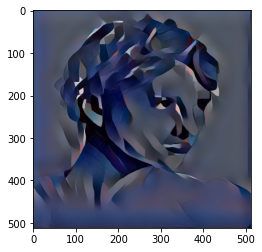

In [ ]:
output,ss ,cs = train_style_transfer(cnn, content_img, style_img, input_img, style_weight=4000)
nout = output.squeeze()
nout.shape
nout = nout.permute(1,2,0)
plt.imshow(nout.cpu().detach().numpy())